# UMAP and clustering


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import cv2
import skimage
import tifffile as tf
import os
import pandas as pd
#import napari
#print(napari.__version__)
#from dask_image.imread import imread
#import dask.array as da
#import io

import platform
if platform.system() == 'Windows':
    fileroot = 'X:/'
    print('Loading Windows')
if platform.system() == 'Linux':
    fileroot = '/home/jovyan/'
    print('Loading Linux')
if False:
    fileroot = '/home/ubuntu/Documents/'
if os.path.exists('/nfs/team283_imaging/') and not os.path.exists('/home/jovyan/'):
    fileroot = '/nfs/team283_imaging/'

colors_new=['#0072b2','#d55e00','#009e73', '#cc79a7','#f0e442','#56b4e9']

import sys
sys.path.append(fileroot+'VU_TEX/Ben_utilities/')
import useful_functions as uf
#import numba_funcs as nf

Loading Linux


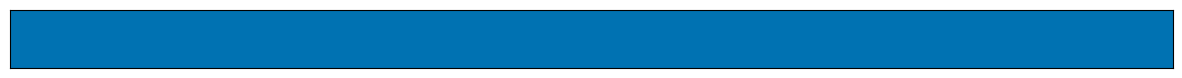

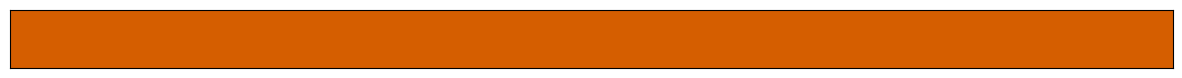

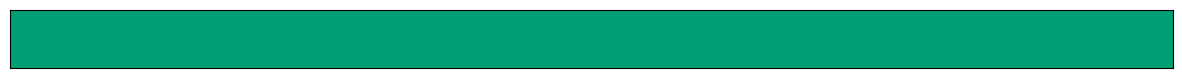

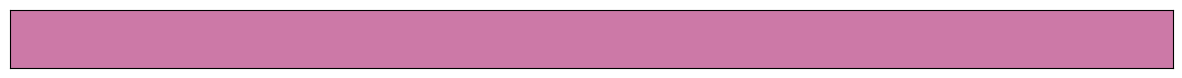

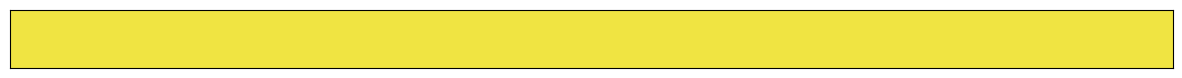

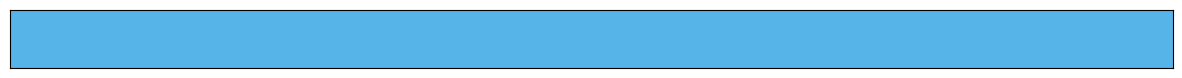

In [2]:
for i, each in enumerate(colors_new):
#    print(i)
    uf.make_Ramp_flexible([each, each])
    plt.show()

In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from tqdm import tqdm, trange
from matplotlib.colors import to_rgba, to_hex
import hdbscan
import umap
from tqdm import tqdm, trange
import fastremap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from numba import njit
import scipy
import pickle
from datetime import datetime

In [4]:
import seaborn as sns
Image.MAX_IMAGE_PIXELS = 100000000000

In [5]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 100)

### Load data

In [6]:
#directory_images_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
directory_images_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
filename_images_metadata = '2022-09-01_IVY_GAP_metadata.csv'
df_images_metadata = pd.read_csv(directory_images_metadata + filename_images_metadata, index_col=0)
df_images_metadata = df_images_metadata.loc[df_images_metadata['original_index'].isin([50, 594, 406, 418, 
267, 290, 474, 231, 498, 217, 
309, 544])]
df_images_metadata

,original_index,annotated,output_filename,output_filename_annotations,bits_per_component,data_set_id,expression_x,height,subimage_id,image_height,image_type,image_width,lims1_id,number_of_components,path,resolution,section_number,structure_id_x,tier_count,width,x,y,failed_facet,section_data_set_id,plane_of_section_id,qc_date,section_thickness,specimen_id,sphinx_id_x,storage_directory,weight_x,donor_id,name_x,rna_integrity_number,hemisphere,structure_id_y,parent_id,parent_x_coord,parent_y_coord,parent_z_coord,external_specimen_name,specimen_id_path,is_ish,sphinx_id_y,weight_y,is_cell_specimen,name_y,age_id,organism_id,strain,sex,condition_description,external_donor_name,sex_full_name,tags,multifocal,recurrence_by_six_months,race_only,donor_sex_facet,donor_strain_facet,donor_race_only_facet,donor_condition_description_facet,primary_tissue_source,chemotherapy,egfr_amplification,extent_of_resection,mgmt_methylation,pten_deletion,radiation_therapy,tumor_status,initial_kps,time_to_progression_or_recurrence,mgmt_ihc,survival_days,molecular_subtype
50,50,False,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...,8.0,273294277,NaN,18080,273294441,44736,Primary,81664,NaN,3.0,/external/gbm/prod1/0534343071/0534343071.aff,0.4945,5,NaN,10,15040,9152,1856,734881840,273294277,7,2013-11-27T18:09:40Z,20.0,268416305,137495,/external/gbm/prod8/image_series_273294277/,5040,12106,H366-0019a.06.A.01,NaN,right,4009,705755,1,1,1,W4-1-1-F.1.01,/705727/705755/268416305/,t,511238,9000,f,H366-0019,79,1,unknown,F,"Survival (in days, integer) Radiationtherapy -...",W4-1-1,Female,H366-0019,No,Yes,unknown,1306038106,2.904992e+09,2.904992e+09,3298293420,Swedish,Yes,No,Complete,No,Yes,Yes,primary,90,102.0,80.0,540.0,"Mesenchymal, Neural"
217,217,True,donor_id_12165_specimen_id_706867_subimage_id_...,donor_id_12165_specimen_id_706867_subimage_id_...,8.0,300631275,False,18048,300631309,29632,Primary,49792,NaN,3.0,/external/gbm/prod3/0539028775_300197737/05390...,0.4945,62,NaN,9,15104,5888,5632,734881840,300631275,9,2014-05-05T17:19:49Z,14.0,706867,110034,/external/gbm/prod21/image_series_300631275/,5190,12165,H366-0029a.04.B.05,NaN,right,4132,706198,5,1,1,W12-1-1-D.2.05,/706190/706198/706867/,t,511657,9000,f,H366-0029,86,1,unknown,F,disease categories - glioblastoma Survival (in...,W12-1-1,Female,H366-0029,No,unknown,unknown,1306038106,2.904992e+09,2.904992e+09,3617011942,Swedish,No,Yes,Sub-total,No,No,No,primary,70,7.0,20.0,80.0,Classical
231,231,False,donor_id_12111_specimen_id_301589924_subimage_...,donor_id_12111_specimen_id_301589924_subimage_...,8.0,302049403,False,18048,302049407,29376,Primary,49792,NaN,3.0,/external/gbm/prod4/0539000884_301628602/05390...,0.4994,294,NaN,9,15104,8064,5632,734881840,302049403,7,2014-07-18T20:42:17Z,14.0,301589924,10192,/external/gbm/prod21/image_series_302049403/,5190,12111,H366-0025a.05.B.03,NaN,left,4084,705834,3,1,1,W10-1-1-E.2.03,/705810/705834/301589924/,t,511394,9000,f,H366-0025,42,1,unknown,F,disease categories - glioblastoma EGFR amplifi...,W10-1-1,Female,H366-0025,No,unknown,unknown,1306038106,2.904992e+09,2.904992e+09,699970192,Swedish,Yes,No,Complete,Yes,No,Yes,primary,100,NaN,0.0,NaN,Proneural
267,267,False,donor_id_12108_specimen_id_298804531_subimage_...,donor_id_12108_specimen_id_298804531_subimage_...,8.0,309715108,False,18048,309715132,46176,Primary,101568,NaN,3.0,/external/gbm/prod8/0539009622_308999323/05390...,0.4970,23,NaN,10,15104,43520,4480,734881840,309715108,8,2014-10-27T20:54:33Z,20.0,298804531,142160,/external/gbm/prod21/image_series_309715108/,5040,12108,H366-0023a.07.B.02,NaN,left,4084,705784,2,1,1,W8-1-1-G.2.02,/705757/705784/298804531/,t,511306,9000,f,H366-0023,26,1,unknown,F,Tumor status - primary PTEN deletion - No EGFR...,W8-1-1,Female,H366-0023,Yes,Yes,unknown,1306038106,2.904992e+09,2.904992e+09,2799164948,Swedish,Yes,No,Complete,No,No,Yes,primary,70,29.0,20.0,442.0,"Classical, Mesenchymal"
290,290,False,donor_id_12111_specimen_id_310607296_

In [7]:
directory_images = fileroot + '0ExternalData/2022-09-01_IVY_GAP/2022-08-31_originals/'
directory_annotated = fileroot + '0ExternalData/2022-09-01_IVY_GAP/2022-09-02_integer_annotations/'
directory_annotated_rescaled = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/2022-11-09_integer_annotations_binned_patchsize_200/'

In [8]:
directory_output_masks = 'HDBScan_Output_masks/'
if not os.path.exists(directory_output_masks):
    os.mkdir(directory_output_masks)

In [9]:
#directory_colors_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
directory_colors_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
filename_colors_metadata = '2022-09-02_colors_for_IVY_GAP.csv'
df_colors = pd.read_csv(directory_colors_metadata + filename_colors_metadata, index_col=0)
df_colors

,color_indices,colors_hex,colors_rgb255,region_names,official_region_names,colorblind_safe,colorblind_optimized,white_first,gray_first
0,0,#FFFFFF,"(255, 255, 255)",Background,Bg,#800080,#ff9999,#Ffffff,#D2d2d2
1,1,#218FA5,"(33, 143, 165)",Leading Edge,LEregion,#218FA5,#006400,#006400,#006400
2,2,#D104D0,"(209, 4, 208)",Infiltrating Tumor,ITregion,#D104D0,#ff1493,#ff1493,#ff1493
3,3,#05D004,"(5, 208, 4)",Cellular Tumor,CTregion,#05D004,#a6730a,#a6730a,#a6730a
4,4,#FF6600,"(255, 102, 0)",Hyperplastic blood vessels,LE_IT_CT_hbv,#FF6600,#ff8c00,#ff8c00,#ff8c00
5,5,#43D1F8,"(67, 209, 248)",Perinecrotic zone,CTpnz,#43D1F8,#00bfff,#00bfff,#00bfff
6,6,#0504D0,"(5, 4, 208)","Pseudopalisading cells, no necrosis",CTpnn,#0504D0,#0000ff,#0000ff,#0000ff
7,7,#05D0AA,"(5, 208, 170)","Pseudopalisading cells, around necrosis",CTpan,#05D0AA,#ffd700,#ffd700,#ffd700
8,8,#FF3300,"(255, 51, 0)",Microvascular proliferation,CTmvp,#006400,#800080,#800080,#800080
9,9,#060505,"(6, 5, 5)",Necrosis,CTne,#060505,#000054,#000054,#000054


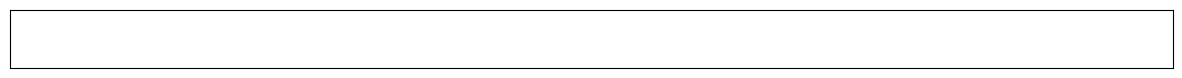

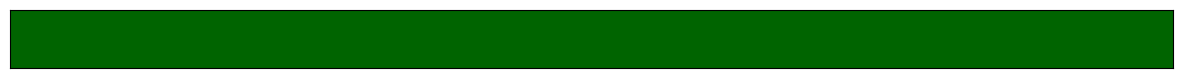

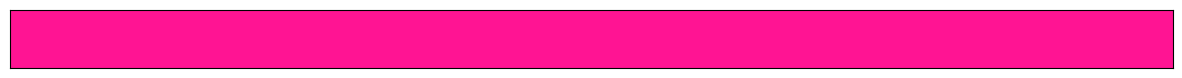

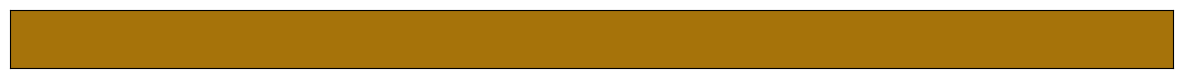

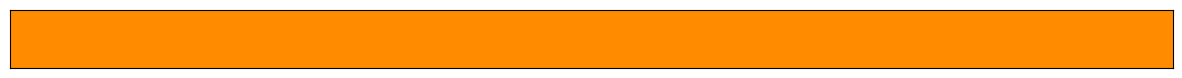

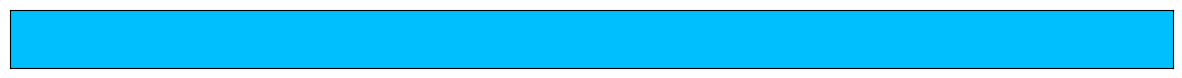

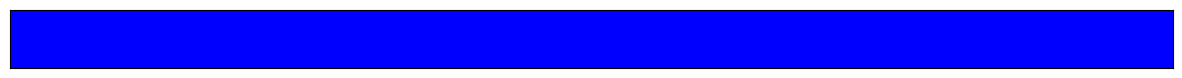

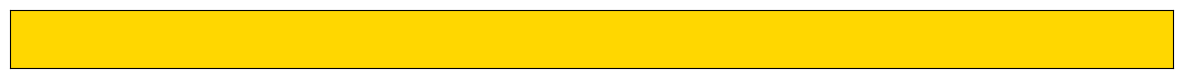

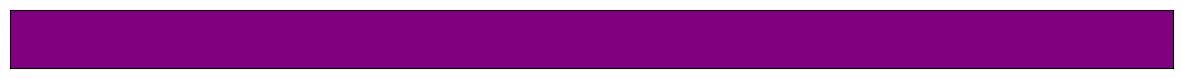

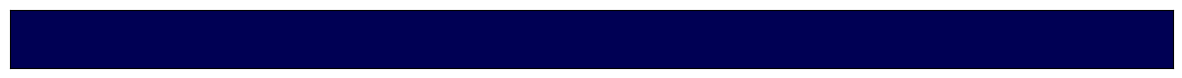

In [10]:
for i, each in enumerate(df_colors['white_first']):
#    print(i)
    uf.make_Ramp_flexible([each, each])
    plt.show()

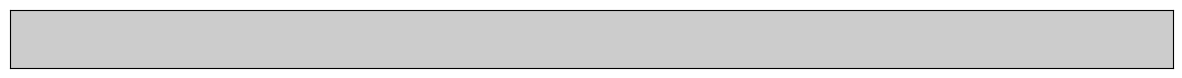

In [11]:
uf.make_Ramp_flexible([(0.8, 0.8, 0.8, 1), (0.8, 0.8, 0.8, 1)]) #0.3 is fine
plt.show()

In [12]:
mycolors = list(df_colors['white_first'])

In [13]:
mycolors

['#Ffffff',
 '#006400',
 '#ff1493',
 '#a6730a',
 '#ff8c00',
 '#00bfff',
 '#0000ff',
 '#ffd700',
 '#800080',
 '#000054']

In [14]:
gray = (0.6, 0.6, 0.6)

In [15]:
dict_colors = {0:to_rgba(mycolors[0]), 
               1:to_rgba(mycolors[1]), 
               2:to_rgba(mycolors[2]),
               3:to_rgba(mycolors[3]),
               4:to_rgba(mycolors[4]),
               5:to_rgba(mycolors[5]),
               6:to_rgba(mycolors[6]),
               7:to_rgba(mycolors[7]),
               8:to_rgba(mycolors[8]),
               9:to_rgba(mycolors[9]),
              np.nan:(1, 1, 1)
              }

dict_color_names = {0:mycolors[0], 
               1:mycolors[1], 
               2:mycolors[2],
               3:mycolors[3],
               4:mycolors[4],
                5:mycolors[5],
               6:mycolors[6],
                7:mycolors[7],
               8:mycolors[8],
                  9:mycolors[9],  
              np.nan:(1, 1, 1)
                   }



In [16]:
#directory_X = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
#filename_X = '2022-10-13_LBP_all_images_data_X_up_to_radius_34.npy'
#X = np.load(directory_X + filename_X, mmap_mode='r')

In [17]:
directory_X_scaled = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/'
#directory_X_scaled = '/lustre/scratch117/cellgen/team283/bw17/VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
filename_X_scaled = '2022-11-09_LBP_all_images_data_X.npy'
X = np.load(directory_X_scaled + filename_X_scaled, mmap_mode='r')
X.shape, X.dtype

((80540, 9416), dtype('uint16'))

In [18]:
directory_VAR = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/'
filename_VAR = '2022-11-09_LBP_all_images_data_VAR.csv'
df_VAR = pd.read_csv(directory_VAR + filename_VAR, index_col=0)
df_VAR.index = df_VAR.index.astype(str)
df_VAR

,0
0,Ch_0_METHOD_uniform_npoints_7_radius_1_value_0
1,Ch_0_METHOD_uniform_npoints_7_radius_1_value_1
2,Ch_0_METHOD_uniform_npoints_7_radius_1_value_2
3,Ch_0_METHOD_uniform_npoints_7_radius_1_value_3
4,Ch_0_METHOD_uniform_npoints_7_radius_1_value_4
...,...
9411,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...
9412,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...
9413,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...
9414,Ch_1_METHOD_uniform_npoints_1157_radius_184_va...


In [19]:
start = datetime.now(); print(start)
directory_OBS = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/'
filename_OBS = '2022-11-09_LBP_all_images_data_OBS.csv'
df_OBS = pd.read_csv(directory_OBS + filename_OBS, index_col=0)
df_OBS['Groundtruth'] = pd.Categorical(df_OBS['Groundtruth'])
df_OBS['original_index'] = pd.Categorical(df_OBS['original_index'])
df_OBS.index = df_OBS.index.astype(str)
display(df_OBS)
datetime.now()-start

2023-05-15 14:54:24.585240


,this_image_index,X0,X1,Groundtruth,original_index,output_filename,output_fname_annotated
0,0,0,0,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
1,1,0,1,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
2,2,0,2,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
3,3,0,3,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
4,4,0,4,0,50,donor_id_12106_specimen_id_268416305_subimage_...,donor_id_12106_specimen_id_268416305_subimage_...
...,...,...,...,...,...,...,...
80535,6745,89,70,3,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...
80536,6746,89,71,0,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...
80537,6747,89,72,0,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...
80538,6748,89,73,0,594,donor_id_13988_specimen_id_278113164_subimage_...,donor_id_13988_specimen_id_278113164_subimage_...


datetime.timedelta(microseconds=139496)

In [20]:
pd.unique(df_OBS['original_index'])

[50, 217, 231, 267, 290, ..., 418, 474, 498, 544, 594]
Length: 12
Categories (12, int64): [50, 217, 231, 267, ..., 474, 498, 544, 594]

474


/nfs/users/nfs_b/bw17/.conda/envs/lbp3b/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/users/nfs_b/bw17/.conda/envs/lbp3b/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


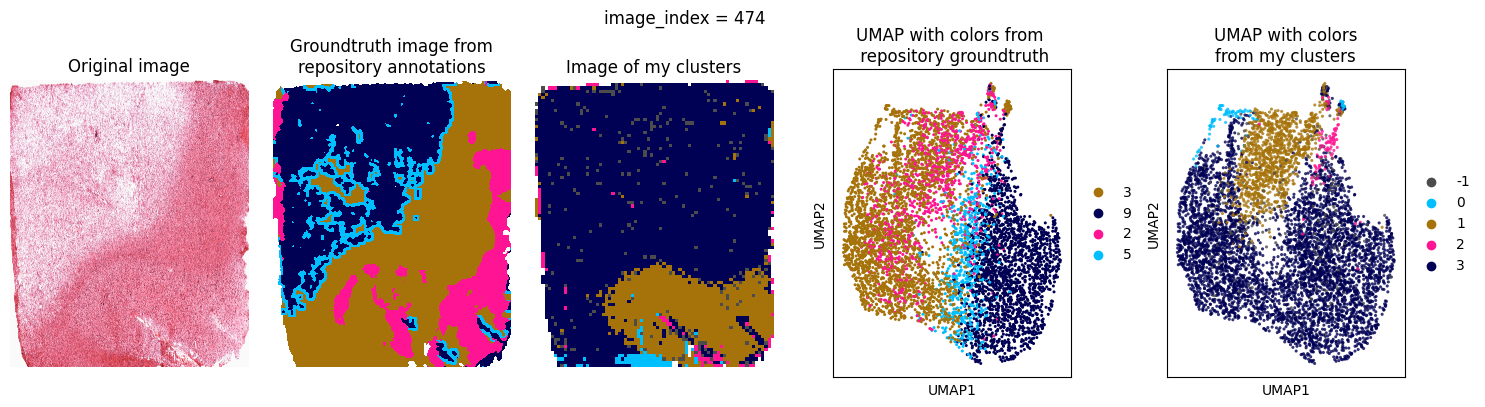

In [22]:
included_images_list = [474]
#included_images_list = [50, 594, 406, 418, 267, 290, 474, 231, 498, 217, 309, 544]

for C, this_image_index in enumerate(included_images_list):
    list_of_index_img0 = df_OBS.index[(df_OBS['original_index'].isin([this_image_index])) &
                                     (~df_OBS['Groundtruth'].isin([0]))] #can add zero in here to remove the background class
    print(this_image_index)
    y = X[list_of_index_img0.astype(int)]
    anndata_concat = ad.AnnData(X=y, obs=df_OBS.loc[list_of_index_img0], var=df_VAR, dtype=np.float32)
    mycolors_list_all = anndata_concat.obs['Groundtruth'].map(dict_color_names)
    mycolors_list_all
    
    Groundtruth_vc = anndata_concat.obs['Groundtruth'].value_counts()
    anndata_concat.obs['Groundtruth'] = anndata_concat.obs['Groundtruth'].cat.set_categories(list(Groundtruth_vc.index[Groundtruth_vc > 0]))
    sc.pp.scale(anndata_concat)
    z = [dict_colors[each] for each in list(anndata_concat.obs['Groundtruth'].value_counts().index)]
    sc.tl.pca(anndata_concat, svd_solver='auto')
    sc.pp.neighbors(anndata_concat, n_neighbors=15, n_pcs=None)
    sc.tl.umap(anndata_concat) #, min_dist=0.0
    
    clusterable_embedding2 = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=20,
    random_state=42,
    ).fit_transform(anndata_concat.X)

    clusterer2 = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=1, cluster_selection_epsilon=0.0,gen_min_span_tree=True)
    clusterer2.fit(clusterable_embedding2)
    anndata_concat.obs['HDBScan_UMAP_clusters'] = pd.Categorical(clusterer2.labels_)#.map({-1:-1, 0:3, 1:9})

    original_fname_annotated = pd.unique(anndata_concat.obs['output_fname_annotated'])[0]
    annotated = np.load(directory_annotated + original_fname_annotated.replace('.jpg', '.npy') )
    annotated_recolor = uf.label2rgb_with_dict(annotated, dict_color_names)
    annotated_rescaled = np.load(directory_annotated_rescaled + original_fname_annotated.replace('.jpg', '.npy') )

    dims = (np.max(anndata_concat.obs['X0']) + 1, np.max(anndata_concat.obs['X1']) + 1)
    heatmap = uf.create_heatmap_from_list_of_coords(dims, anndata_concat.obs['X0'], anndata_concat.obs['X1'], 
                                           anndata_concat.obs['HDBScan_UMAP_clusters'], scale_up = 1,
                                           bg_value=-2, dtype=np.uint8)
#    this_colors_dict = {key:value for key, value in zip(anndata_concat.obs['HDBScan_UMAP_clusters'].cat.categories,
#                                                                                        anndata_concat.uns['HDBScan_UMAP_clusters_colors'])}
#    this_colors_dict = dict_colors
#    this_colors_dict[-2] = mycolors[0]
#    heatmap_recolor = uf.label2rgb_with_dict(heatmap, this_colors_dict)
    annotated_rescaled = annotated_rescaled[0:heatmap.shape[0], 0:heatmap.shape[1]]
    classes_mapping_dict, overlap = uf.get_optimal_overlap_of_classes(heatmap, annotated_rescaled, 
                                                                  elements_to_remove_from_observed = [-2, -1])
    # -2 is the class that is background I think
    observed_classes_to_colors = {key: dict_colors[value] for key,value in classes_mapping_dict.items() if value is not np.nan}
    observed_classes_to_colors[-2] = (1.0, 1.0, 1.0, 1.0)
    observed_classes_to_colors[-1] = (0.3, 0.3, 0.3, 1.0)
    remaining_classes = list(set(classes_mapping_dict.keys()) - set(observed_classes_to_colors.keys()))
    N_rem = len(remaining_classes)
    for i, each in enumerate(remaining_classes):
    #    observed_classes_to_colors[each] = ((i+1)/(N_rem+1), (i+1)/(N_rem+1), (i+1)/(N_rem+1), 1.0)
        observed_classes_to_colors[each] = to_rgba(colors_new[i])
    heatmap_recolor = uf.label2rgb_with_dict(heatmap, observed_classes_to_colors)
    
    observed_classes_to_colors_for_umap = {key:to_hex(value) for key, value in observed_classes_to_colors.items()
                                          if key in heatmap}
    sorted_keys = sorted(observed_classes_to_colors_for_umap.keys())
    sorted_keys.remove(-2)
    anndata_concat.uns['HDBScan_UMAP_clusters_colors'] = [observed_classes_to_colors_for_umap[each] for
                                                          each in sorted_keys]
    
    
    gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 1, 0.1, 1, 0.25, 1, 0.4, 1])
    fig, ax = plt.subplots(1,9, figsize=(18,4), gridspec_kw=gridspec) #, 
#    sc.pl.pca(anndata_concat, color='Groundtruth',
#                 size=1, palette=dict_colors, components=['1,2'], ax=ax[0], show=False,
#             title='PCA with colors\nfrom groundtruth')
    
    img_name = pd.unique(anndata_concat.obs['output_filename'])[0]
    img = skimage.io.imread(directory_images + img_name)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original image')
    sc.pl.umap(anndata_concat, color=['Groundtruth'],          
                 palette=dict_colors, show=False, alpha=1, ax=ax[6],
              title='UMAP with colors from \n repository groundtruth')
    sc.pl.umap(anndata_concat, color=['HDBScan_UMAP_clusters'], 
                 size=20, show=False, alpha=0.8, ax=ax[8],
              title='UMAP with colors\nfrom my clusters')
    ax[2].imshow(annotated_recolor, interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Groundtruth image from\nrepository annotations')
    ax[4].imshow(heatmap_recolor, interpolation='none')
    ax[4].axis('off')
    ax[4].set_title('Image of my clusters')
    for this_ax in [ax[1], ax[3], ax[5], ax[7]]:
        this_ax.axis('off')
    plt.suptitle('image_index = ' + str(this_image_index), y=1.03)
    plt.savefig('image_index_' + str(this_image_index) + '.png', dpi=400, bbox_inches='tight', pad_inches=0.01)
    plt.show()
    
    
    np.save(directory_output_masks + 'C_' + str(C) + '_Imageindex_' + str(this_image_index) + '_ints', heatmap)
    np.save(directory_output_masks + 'C_' + str(C) + '_Imageindex_' + str(this_image_index) + '_rgb', heatmap_recolor)
#    break